In [14]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import copy

In [28]:
trialState = np.load('/data/LLMs/willet/data/trialState.npy')
ba6 = np.load('/data/LLMs/willet/regression_data/smooth_ba6v_pow.npy')
audioEnvelope = np.load('/data/LLMs/willet/data/audioEnvelope.npy')

In [29]:
go_period_idxs = np.argwhere(trialState==1).squeeze()
audio_go = np.zeros_like(audioEnvelope)
audio_go[go_period_idxs] = audioEnvelope[go_period_idxs]

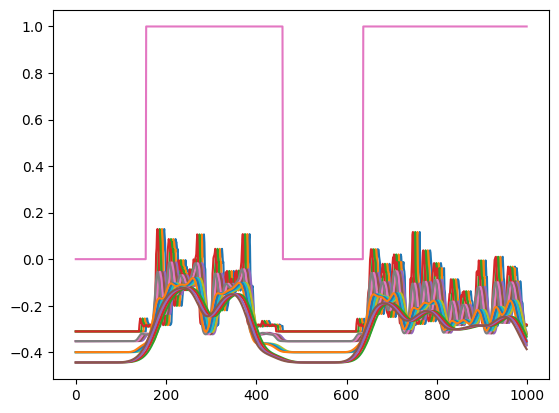

In [30]:
sigma = [0,5,10,20]
delays = [0,5,10,15] # 0, 100ms, 200ms, and 300ms delays
audio_features = []
for s in sigma:
    
    if s != 0:
        audio_go_smooth = gaussian_filter1d(audio_go, sigma=s)
    else:
        audio_go_smooth = copy.deepcopy(audio_go)
        
    for d in delays:
        # shift audio backwards in time by d timesteps 
        # the reason for this is neural data corresponding to the speech production
        # occurs slightly before speech production. We can shift backwards by starting
        # at time d. Pad with zeros to keep the shape constant. 
        audio_go_smooth_delayed = np.pad(audio_go_smooth[d:], (0,d))
        
        audio_features.append(audio_go_smooth_delayed)
        
audio_features_np = np.vstack((audio_features)).T
# audio_features_np has shape (n_time_points, n_features)
# Compute the mean and standard deviation along the time dimension (axis=0)
mean = np.mean(audio_features_np, axis=0)
std = np.std(audio_features_np, axis=0)

# Avoid division by zero by adding a small epsilon
epsilon = 1e-8
standardized_audio_features_np = (audio_features_np - mean) / (std + epsilon)

np.save('/data/LLMs/willet/regression_data/audio_features', standardized_audio_features_np)
plt.plot(standardized_audio_features_np[0:1000])
plt.plot(trialState[0:1000]*1)
plt.show()

In [20]:
trialState_binary = np.expand_dims(np.zeros_like(trialState),axis=-1)
trialState_binary[trialState==1] = 1
np.save('/data/LLMs/willet/regression_data/trialState_binary', trialState_binary)

In [21]:
ba44 = np.load('/data/LLMs/willet/regression_data/smooth_ba44_pow.npy')

In [31]:
ba44_go_audio = np.hstack((ba44, trialState_binary, standardized_audio_features_np))

In [32]:
np.save('/data/LLMs/willet/regression_data/ba44_go_audio', ba44_go_audio)

In [33]:
np.save('/data/LLMs/willet/regression_data/go_audio', np.hstack((trialState_binary, standardized_audio_features_np)))

In [ ]:
np.save('/data/LLMs/willet/regression_data/ba44_go_audio', np.hstack((ba44, trialState_binary))